In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [8]:
def smart_money_strength(df, window=60, volatility_window=20):
    """
    改进的聪明钱强度因子
    金融学原理：
    1. 使用主动买入比例而非绝对量，消除规模影响
    2. 引入资金效率概念（成交额/成交量）
    3. 加入波动率调整和趋势确认机制
    """
    close = df['close']
    high = df['high']
    low = df['low']
    volume = df['volume']
    taker_volume = df['taker_buy_volume']
    
    # 1. 主力资金比例 (Taker Ratio)
    taker_ratio = taker_volume / volume.replace(0, 1e-12)
    
    # 2. 资金效率 (Price Impact per Volume)
    # 衡量单位成交量对价格的影响
    price_range = high - low
    volume_efficiency = (price_range / volume.replace(0, 1e-12)).replace(np.inf, 0)
    
    # 3. 主力资金净流向
    # 使用收盘价位置判断主力意图
    position_ratio = (close - low) / (high - low).replace(0, 1e-12)
    net_flow = taker_ratio * position_ratio
    
    # 4. 波动率调整
    volatility = price_range.rolling(volatility_window).std()
    
    # 5. 趋势确认
    ma_short = close.rolling(5).mean()
    ma_long = close.rolling(20).mean()
    trend_strength = (ma_short - ma_long) / close
    
    # 综合因子
    raw_factor = net_flow * volume_efficiency
    adjusted_factor = raw_factor.rolling(window).mean() / (volatility + 1e-12)
    final_factor = adjusted_factor * np.where(trend_strength > 0, 1, -1)
    
    return final_factor

def order_flow_imbalance(df, window=30):
    """
    机构订单流不平衡因子
    金融学原理：大额订单流不平衡预示价格方向变化
    """
    # 计算主动买入/卖出压力
    buy_pressure = df['taker_buy_volume'] * df['close']
    sell_pressure = (df['volume'] - df['taker_buy_volume']) * df['close']
    
    # 订单流不平衡
    ofi = (buy_pressure - sell_pressure) / (buy_pressure + sell_pressure).replace(0, 1e-12)
    
    # 平滑处理
    smoothed_ofi = ofi.rolling(window).mean()
    
    # 结合波动率调整
    volatility = (df['high'] - df['low']).rolling(window).std()
    return smoothed_ofi / (volatility + 1e-12)

def liquidity_gap_factor(df, window=20):
    """
    流动性缺口因子
    金融学原理：流动性突然变化预示价格趋势加速
    """
    # 计算买卖价差 (隐含)
    bid_ask_spread = (df['high'] - df['low']) / df['close']
    
    # 流动性冲击指标
    volume_change = df['volume'].pct_change()
    turnover_change = df['turnover'].pct_change()
    liquidity_shock = np.sign(volume_change) * np.abs(turnover_change)
    
    # 缺口识别
    gap_up = (df['low'] > df['high'].shift(1)).astype(int)
    gap_down = (df['high'] < df['low'].shift(1)).astype(int)
    gap_strength = (gap_up - gap_down) * (df['close'] - df['open']) / df['open']
    
    # 综合因子
    raw_factor = liquidity_shock * bid_ask_spread
    gap_adjusted = raw_factor * (1 + gap_strength)
    return gap_adjusted.rolling(window).mean()

def smart_money_divergence(df, price_window=30, volume_window=10):
    """
    聪明钱背离指标
    金融学原理：当主力资金流向与价格走势背离时，预示反转
    """
    # 价格动量
    price_momentum = df['close'].pct_change(price_window)
    
    # 聪明钱动量
    taker_momentum = df['taker_buy_volume'].rolling(volume_window).mean().pct_change(volume_window)
    
    # 交易量确认
    volume_confirmation = np.sign(df['volume'].pct_change(volume_window))
    
    # 背离检测
    price_trend = np.sign(price_momentum.rolling(3).mean())
    taker_trend = np.sign(taker_momentum.rolling(3).mean())
    
    divergence = np.where(price_trend != taker_trend, 
                         (taker_momentum - price_momentum) * volume_confirmation,
                         0)
    
    # 波动率加权
    volatility = df['high'].rolling(price_window).std() / df['close']
    return divergence / (volatility + 1e-12)

def market_depth_pressure(df, window=15):
    """
    市场深度压力指数
    金融学原理：订单簿深度变化反映市场供需平衡
    (使用交易数据间接估算)
    """
    # 价格效率系数
    price_efficiency = np.abs(df['close'] - df['open']) / (df['high'] - df['low']).replace(0, 1e-12)
    
    # 交易密度
    trade_density = df['trade_count'] / df['volume'].replace(0, 1e-12)
    
    # 主力参与度
    taker_participation = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    
    # 深度压力
    depth_pressure = (1 - price_efficiency) * trade_density * taker_participation
    
    # 标准化
    return (depth_pressure - depth_pressure.rolling(window).mean()) / depth_pressure.rolling(window).std()

def volatility_compression_breakout(df, compression_window=30, breakout_window=5):
    """
    波动压缩突破因子
    金融学原理：低波动期后突破往往有较强持续性
    """
    # 波动率计算
    true_range = np.maximum.reduce([
        df['high'] - df['low'],
        np.abs(df['high'] - df['close'].shift(1)),
        np.abs(df['low'] - df['close'].shift(1))
    ])
    
    volatility = true_range.rolling(compression_window).mean()
    
    # 波动压缩检测
    volatility_ratio = volatility / volatility.rolling(compression_window).std()
    compression_signal = (volatility_ratio < 0.5).astype(int)
    
    # 突破检测
    breakout_signal = ((df['close'] > df['high'].shift(1)) | 
                      (df['close'] < df['low'].shift(1))).astype(int)
    
    # 突破强度
    breakout_strength = np.where(
        df['close'] > df['high'].shift(1),
        (df['close'] - df['high'].shift(1)) / df['close'],
        (df['low'].shift(1) - df['close']) / df['close']
    )
    
    # 主力资金确认
    taker_confirmation = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    if df['close'] < df['low'].shift(1):
        taker_confirmation = 1 - taker_confirmation
    
    # 综合因子
    return compression_signal * breakout_signal * breakout_strength * taker_confirmation

def composite_factor(df):
    """综合因子组合"""
    f1 = smart_money_strength(df)
    f2 = order_flow_imbalance(df)
    f3 = smart_money_divergence(df)
    f4 = volatility_compression_breakout(df)
    
    # 标准化
    f1_norm = (f1 - f1.mean()) / f1.std()
    f2_norm = (f2 - f2.mean()) / f2.std()
    f3_norm = (f3 - f3.mean()) / f3.std()
    f4_norm = (f4 - f4.mean()) / f4.std()
    
    # 动态权重：在趋势市加强趋势因子，震荡市加强反转因子
    trend_strength = df['close'].rolling(50).std() / df['close']
    trend_weight = np.clip(trend_strength * 10, 0.2, 0.8)
    
    composite = (
        trend_weight * (f1_norm + f2_norm) + 
        (1 - trend_weight) * (f3_norm + f4_norm)
    )
    return composite

# 因子测试

In [9]:
evaluator.set_factor(
    factor_func=composite_factor,
    factor_name='composite_factor'
)

ValueError: 因子函数执行失败: 'numpy.ndarray' object has no attribute 'rolling'


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.010112
   Rank_IC (Spearman): -0.015533
📊 信息比率:
   IR: -0.527772
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130881
   因子列: smart_money_strength
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


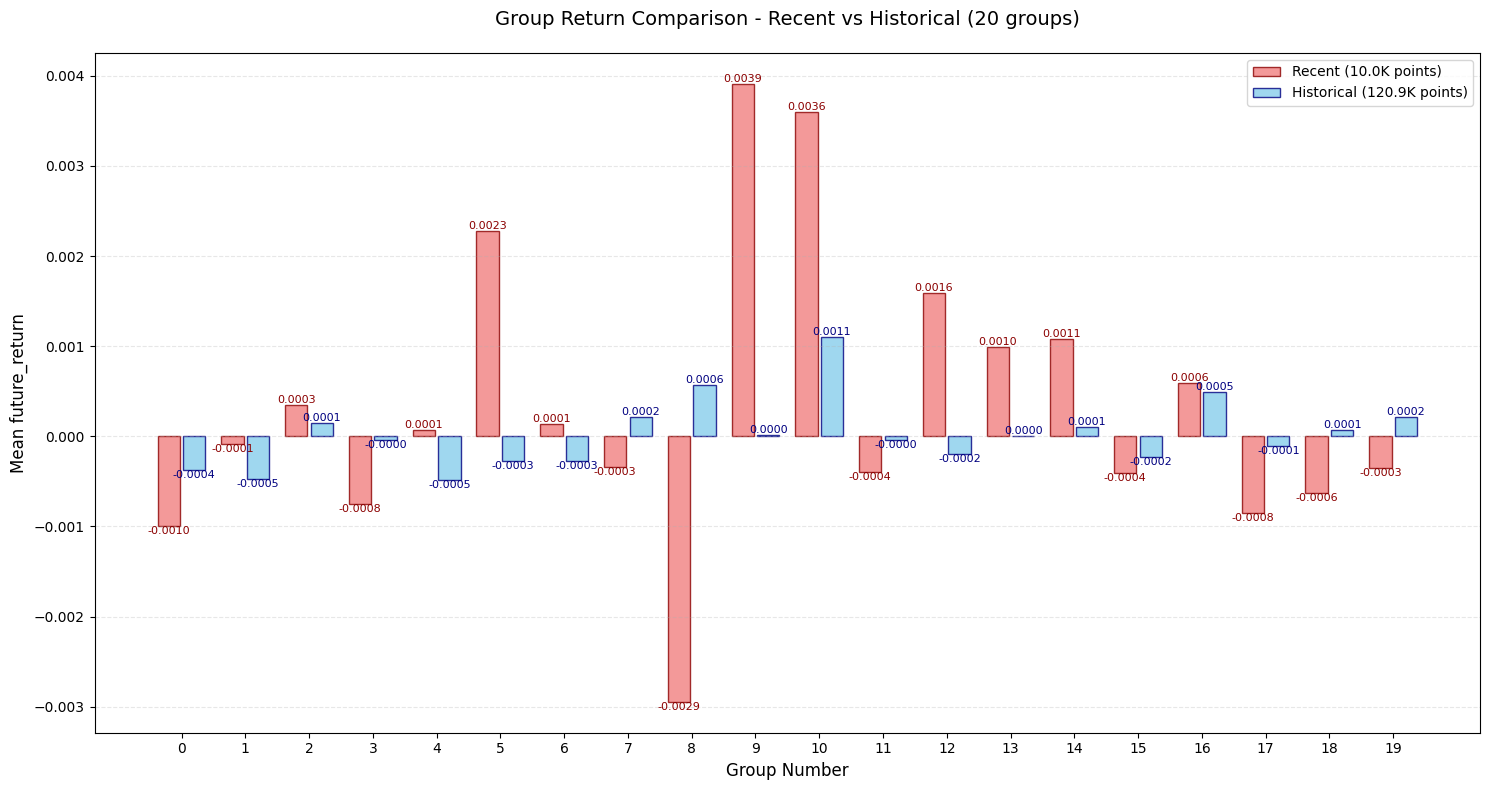

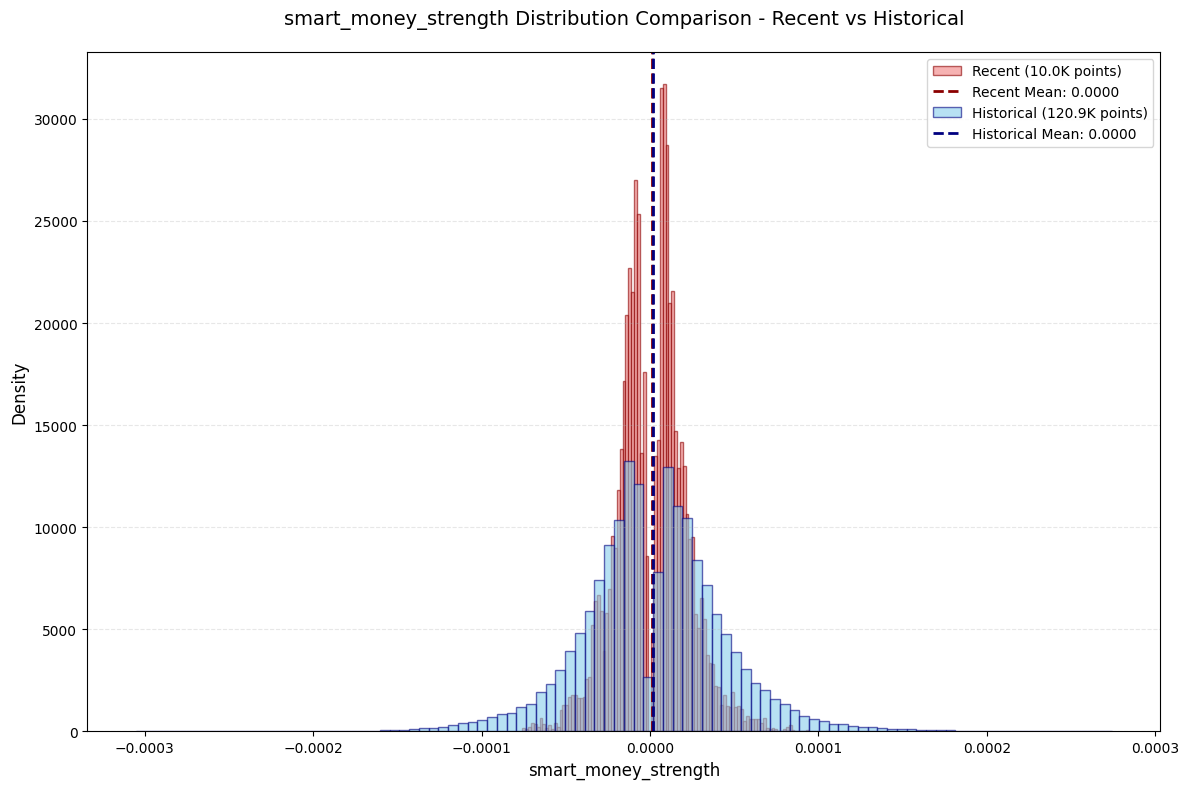

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [ ]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [ ]:
print(result)

{'correlation_analysis': {'IC': 0.01011157682122146, 'Rank_IC': -0.015533288851805627}, 'information_ratio': {'IR': -0.5277720204669315, 'group_correlations': [-0.01678029532445444, -0.013517347264078342, 0.008208240534590442, 0.012590468174276588, -0.010998488875431991, -0.04483799943130625, 0.0003168851368116574, -0.011655451971632251, -0.015182745996397717, 0.007737934760526229], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -0.0003  -0.0001   -0.0001      -0.0004      0.0081   6545
1      -0.0001  -0.0000   -0.0001      -0.0005      0.0090   6544
2      -0.0000  -0.0000   -0.0000       0.0003      0.0098   6544
3      -0.0000  -0.0000   -0.0000      -0.0002      0.0099   6544
4      -0.0000  -0.0000   -0.0000      -0.0005      0.0113   6544
5      -0.0000  -0.0000   -0.0000      -0.0003      0.0116   6544
6      -0.0000  -0.0000   -0.0000  